**Deep Learning Tutorial**, Azar 19 at 17:00 via Skype 
Class Room, DL Recitation, Session Tweleve

[Deep Learning](https://github.com/hhaji/Deep-Learning), Data Science Center, Shahid Beheshti University

Presented and prepared by [‌‌Yavar Yeganeh](https://github.com/YavarYeganeh)




**Acknowledgment and References:**

* [Pytorch](www.Pytorch.org)

* Others listed throughout the notebook


<table align="left">
  <td>
    <a target="_blank" href=https://colab.research.google.com/drive/1xm90WDOSxWzAu5F6m9Cf1IYg-xxI2S54?usp=sharing"><img src="https://colab.research.google.com/img/colab_favicon_256px.png" height="100" width="100" /> <br>  Run in Google Colab</a>
  </td>
</table>

We'll discuss:

   - Introcuction to Transfer Learning
   - Implementation of TL
   - A few examples in PyTorch

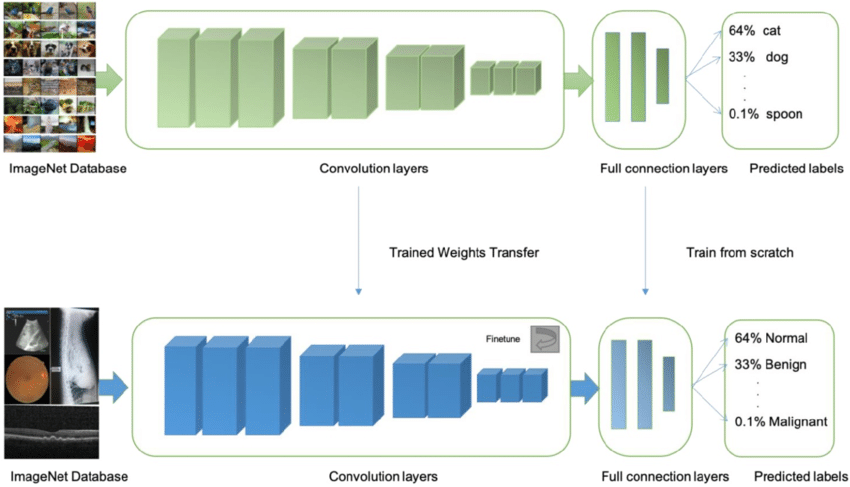


Src: [Current status and future trends of clinical diagnoses via image-based deep learning ](https://www.researchgate.net/publication/336874848_Current_status_and_future_trends_of_clinical_diagnoses_via_image-based_deep_learning)


Transfer Learning for Computer Vision Tutorial
==============================================
Based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

**Original Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In [ ]:
%matplotlib inline




In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [ ]:
# License: BSD
# Original Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [ ]:
# Downloading Data
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2020-12-09 12:09:49--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.204.34, 13.32.204.49, 13.32.204.65, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.204.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  86.2MB/s    in 0.5s    

2020-12-09 12:09:49 (86.2 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
!ls

hymenoptera_data  hymenoptera_data.zip	sample_data


In [ ]:
!unzip hymenoptera_data.zip
!ls

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(dataset_sizes)
print(class_names)
print(device)

{'train': 244, 'val': 153}
['ants', 'bees']
cuda:0


In [ ]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f9dd9afae48>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f9dd9df59e8>}

In [ ]:
dataloaders['train']

Visualization

^^^^^^^^^^^^^^^^^^^^^^

Let's visualize a few training images so as to understand the data
augmentations.



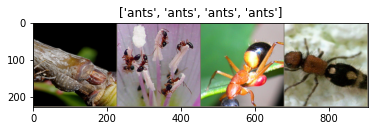

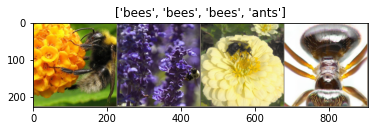

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
vals, v_classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

out_v= torchvision.utils.make_grid(vals)
imshow(out_v, title=[class_names[x] for x in v_classes])


Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4753 Acc: 0.7254
val Loss: 0.2702 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.5338 Acc: 0.7992
val Loss: 0.3065 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4591 Acc: 0.8074
val Loss: 0.2971 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.3604 Acc: 0.8197
val Loss: 0.3626 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.4081 Acc: 0.8279
val Loss: 0.3964 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.7205 Acc: 0.7746
val Loss: 0.3504 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.5700 Acc: 0.7951
val Loss: 0.5879 Acc: 0.8366

Epoch 7/24
----------
train Loss: 0.4140 Acc: 0.8730
val Loss: 0.2796 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3944 Acc: 0.8279
val Loss: 0.1982 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4693 Acc: 0.8238
val Loss: 0.2063 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3316 Acc: 0.8566
val Loss: 0.2064 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3162 Acc: 0.8770
val Loss: 0.2350 Acc: 0.9085

Ep

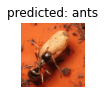

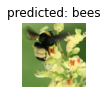

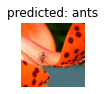

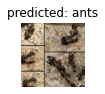

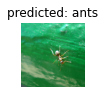

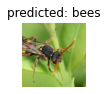

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5203 Acc: 0.7090
val Loss: 0.2210 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4087 Acc: 0.7992
val Loss: 0.1674 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.5968 Acc: 0.7459
val Loss: 0.2889 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.5828 Acc: 0.7787
val Loss: 0.3597 Acc: 0.8497

Epoch 4/24
----------
train Loss: 0.6538 Acc: 0.7541
val Loss: 0.1698 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3408 Acc: 0.8443
val Loss: 0.1707 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3765 Acc: 0.8730
val Loss: 0.2045 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3952 Acc: 0.8361
val Loss: 0.1526 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3257 Acc: 0.8648
val Loss: 0.1522 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.2788 Acc: 0.8852
val Loss: 0.1645 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3398 Acc: 0.8402
val Loss: 0.1483 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.4116 Acc: 0.8074
val Loss: 0.1620 Acc: 0.9542

Ep

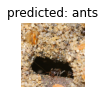

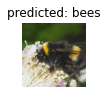

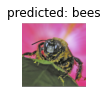

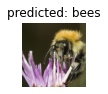

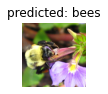

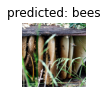

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.





# Chapter 4: Transfer Learning And Other Tricks

Based on https://github.com/falloutdurham/beginners-pytorch-deep-learning/blob/master/chapter4/Chapter%204.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

* TORCHVISION.MODELS: https://pytorch.org/docs/stable/torchvision/models


* Some models use modules which have different training and evaluation behavior, such as batch normalization. To switch between these modes, use model.train() or model.eval() as appropriate. See train() or eval() for details.

* All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:

In [ ]:
transfer_model_raw= models.resnet152()
transfer_model = models.resnet152(pretrained=True) 

In [ ]:
transfer_model_raw

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
transfer_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Freezing parameters

In [ ]:
print('transfer_model.conv1.weight \n',transfer_model.conv1.weight)
print('\n transfer_model.bn1.weight \n',transfer_model.bn1.weight)
print('\n transfer_model.bn1.bias \n', transfer_model.bn1.bias)

transfer_model.conv1.weight 
 Parameter containing:
tensor([[[[ 4.7132e-07,  6.3123e-07,  6.1915e-07,  ...,  2.9313e-07,
            2.1123e-07,  1.3036e-07],
          [ 4.8263e-07,  7.1548e-07,  7.1251e-07,  ...,  3.0581e-07,
            2.6611e-07,  2.3413e-07],
          [ 4.9888e-07,  6.3326e-07,  6.1920e-07,  ...,  1.2629e-07,
            1.8429e-07,  2.0732e-07],
          ...,
          [ 5.5013e-07,  3.1735e-07,  4.1098e-07,  ...,  3.1079e-07,
            3.4928e-07,  3.4718e-07],
          [ 6.2982e-07,  4.0325e-07,  3.4432e-07,  ...,  4.8297e-07,
            6.4529e-07,  5.4214e-07],
          [ 7.1402e-07,  5.0883e-07,  4.4785e-07,  ...,  6.2946e-07,
            6.5617e-07,  5.0979e-07]],

         [[ 5.0878e-07,  6.8802e-07,  6.1782e-07,  ...,  2.2142e-07,
            2.1541e-07,  1.8464e-07],
          [ 4.2393e-07,  6.5220e-07,  6.2894e-07,  ...,  2.8318e-07,
            2.5690e-07,  2.3177e-07],
          [ 4.6649e-07,  6.4230e-07,  6.2854e-07,  ...,  1.3226e-07,
      

In [ ]:
for name, param in transfer_model.named_parameters():
  print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [ ]:
for name, param in transfer_model.named_parameters():
    if("bn" not in name): # bn stands for BatchNorm layer; You can let this layer to be trained as you're working with a new dataset. 
        param.requires_grad = False # freezing trained layers

## Replacing the classifier

In [ ]:
# transfer_model.fc was Linear(in_features=2048, out_features=1000, bias=True)
transfer_model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features, 600),
nn.ReLU(),                                 
nn.Dropout(), nn.Linear(600,2)) 
transfer_model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=600, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=600, out_features=2, bias=True)
)

In [ ]:
transfer_model.eval()
transfer_model(torch.randn(1,3,256,256))

tensor([[-0.1589,  0.0716]], grad_fn=<AddmmBackward>)

## Training Again

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()  ##
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.4f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [ ]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

# Data augmentation and normalization for training
# Just normalization for validation
transforms_train= transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transforms_val= transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
   ] )
train_data_path = "./hymenoptera_data/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=transforms_train, is_valid_file=check_image)
val_data_path = "./hymenoptera_data/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=transforms_val, is_valid_file=check_image)
batch_size=16
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [ ]:
print(len(train_data_loader.dataset),len(val_data_loader.dataset))

245 153


In [ ]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

In [ ]:
# torch.cuda.empty_cache() 
!nvidia-smi

Wed Dec  9 12:49:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |   1193MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, epochs=24,
      device=device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1, Training Loss: 0.1303, Validation Loss: 0.2189, accuracy = 0.9346
Epoch: 2, Training Loss: 0.0930, Validation Loss: 0.1951, accuracy = 0.9281
Epoch: 3, Training Loss: 0.1354, Validation Loss: 0.2041, accuracy = 0.9281
Epoch: 4, Training Loss: 0.0871, Validation Loss: 0.2538, accuracy = 0.9150
Epoch: 5, Training Loss: 0.0767, Validation Loss: 0.2365, accuracy = 0.9281
Epoch: 6, Training Loss: 0.0810, Validation Loss: 0.2008, accuracy = 0.9346
Epoch: 7, Training Loss: 0.1359, Validation Loss: 0.2079, accuracy = 0.9216
Epoch: 8, Training Loss: 0.0780, Validation Loss: 0.2051, accuracy = 0.9216
Epoch: 9, Training Loss: 0.0482, Validation Loss: 0.1997, accuracy = 0.9281
Epoch: 10, Training Loss: 0.0360, Validation Loss: 0.2216, accuracy = 0.9216
Epoch: 11, Training Loss: 0.0515, Validation Loss: 0.2282, accuracy = 0.9281
Epoch: 12, Training Loss: 0.0875, Validation Loss: 0.1686, accuracy = 0.9477
Epoch: 13, Training Loss: 0.0425, Validation Loss: 0.1996, accuracy = 0.9281
Epoch: 1

## LR Finder

In [ ]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses


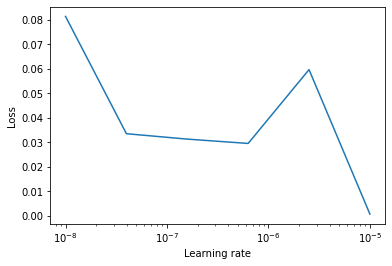

In [ ]:
(lrs, losses) = find_lr(transfer_model, torch.nn.CrossEntropyLoss(),optimizer, train_data_loader,device=device)
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

In [ ]:
optimizer = optim.Adam(transfer_model.parameters(), lr=0.00001)
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, epochs=24,
      device=device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1, Training Loss: 0.0631, Validation Loss: 0.2049, accuracy = 0.9412
Epoch: 2, Training Loss: 0.0730, Validation Loss: 0.2116, accuracy = 0.9477
Epoch: 3, Training Loss: 0.0620, Validation Loss: 0.2216, accuracy = 0.9346
Epoch: 4, Training Loss: 0.0680, Validation Loss: 0.2028, accuracy = 0.9412
Epoch: 5, Training Loss: 0.0274, Validation Loss: 0.2112, accuracy = 0.9412
Epoch: 6, Training Loss: 0.0704, Validation Loss: 0.2146, accuracy = 0.9412
Epoch: 7, Training Loss: 0.0958, Validation Loss: 0.2108, accuracy = 0.9412
Epoch: 8, Training Loss: 0.0826, Validation Loss: 0.2111, accuracy = 0.9412
Epoch: 9, Training Loss: 0.1075, Validation Loss: 0.2198, accuracy = 0.9412
Epoch: 10, Training Loss: 0.0267, Validation Loss: 0.2119, accuracy = 0.9346
Epoch: 11, Training Loss: 0.0336, Validation Loss: 0.2116, accuracy = 0.9412
Epoch: 12, Training Loss: 0.0822, Validation Loss: 0.2062, accuracy = 0.9412
Epoch: 13, Training Loss: 0.1315, Validation Loss: 0.2116, accuracy = 0.9346
Epoch: 1

## Custom Transforms

Here we'll create a lambda transform and a custom transform class.

In [ ]:
def _random_colour_space(x):
    output = x.convert("HSV")
    return output 

In [ ]:
colour_transform = transforms.Lambda(lambda x: _random_colour_space(x))

In [ ]:
random_colour_transform = torchvision.transforms.RandomApply([colour_transform])

In [ ]:
class Noise():
    """Adds gaussian noise to a tensor.
    
    Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     Noise(0.1, 0.05)),
        >>> ])
    
    """
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)
    
    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean},sttdev={self.stddev})"
        return repr

In [ ]:
custom_transform_pipeline = transforms.Compose([random_colour_transform, Noise(0.1, 0.05)])

## Ensembles

Given a list of models, we can produce predictions for each model and then make an average to make a final prediction.

In [ ]:
models_ensemble = [models.resnet50().to(device), models.resnet50().to(device)]
predictions = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in models_ensemble] 
avg_prediction = torch.stack(predictions).mean(0).argmax()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
avg_prediction

tensor(882, device='cuda:0')

In [ ]:
torch.stack(predictions)

tensor([[[0.0009, 0.0025, 0.0005,  ..., 0.0011, 0.0015, 0.0006]],

        [[0.0006, 0.0010, 0.0017,  ..., 0.0007, 0.0014, 0.0028]]],
       device='cuda:0', grad_fn=<StackBackward>)